# NAIAD Active Learning Pipeline

In this tutorial, we’ll demonstrate the core features of NAIAD active learning framework through two key scenarios:

1. **Active Learning Pipeline**: Iteratively select the most informative perturbations for model refinement ( for AI-Lab-Loop experimental setups).  
2. **Active Learning Pipeline with Replicates**: Leverage ensembling methods to identify the most promising perturbations with higher confidence through iterative data collection and model training cycles.

We'll use the [Norman2019](https://www.science.org/doi/10.1126/science.aax4438) combinatorial perturbation dataset—comprising CRISPRa pairwise genetic perturbations for roughly 120 genes—as a primary example.

Additionally, you can try these pipelines on the [Simpson2023](https://www.biorxiv.org/content/10.1101/2023.08.19.553986v1) and [Horlbeck2018](https://www.cell.com/cell/fulltext/S0092-8674(18)30735-9) datasets, both located in the `./data` subfolder of this `tutorials` directory.

## Set up notebook

In [1]:
import os
import logging
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import tqdm 
import matplotlib.pyplot as plt
from naiad import load_naiad_data, NAIAD, ActiveLearner, ActiveLearnerReplicates
# set some configuration settings for the notebook
logging.basicConfig(level=logging.WARN)
pd.set_option("mode.copy_on_write", True)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')

## Active Learning Pipeline

In this example, we demonstrate an active learning process using symmetrical screening data from [Norman2019](https://www.science.org/doi/10.1126/science.aax4438). We begin by uniformly sampling gene pairs to train an ensemble of NAIAD models, then use the trained ensemble to predict unseen combinations across the entire combinatorial space. By “ensemble,” we mean that we initialize model weights `n_ensemble` times with the same training data.

Next, we select additional training samples with the `ActiveLearner` class by specifying the `method` parameter, which can be `'mean'`, `'std'`, `'mean+std'`, `'residual'`, `'residual+std'`, or `'leverage'`. The `method_min` parameter controls whether we maximize or minimize the chosen metric.

Within `ActiveLearner`, you can configure both the number of rounds and how many new samples are acquired each round. In this tutorial, we run five rounds, adding 100 new gene pairs per round. You can adjust these parameters according to your experimental needs. For more details, see `help(ActiveLearner)`.

In [3]:
# provide path to relevant data directories
data_file = './data/norman_gamma.csv'
result_dir = './results/active_learning'

# parameters for initializing and running model
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)
seed = 42
batch_size = 4096

In [4]:
# active learning pipeline arguments
n_round = 5
n_sample = [100, 200, 300, 400, 500] # number of samples to use in each learning round
test_frac = 0.3


n_ensemble = 3     # how many ensembles to use for each round?
n_epoch = 10       # how long to train each instance of the model

method = 'mean'    # active learning method
method_min = True  # method_min checks if we should minimize the value (for 'mean' it is set to True since we are minimizing cell viability)

In [5]:
naiad_data = load_naiad_data(data_file)
active_learner = ActiveLearner(n_round = n_round, 
                               data = naiad_data,
                               n_ensemble = n_ensemble,
                               n_epoch = n_epoch,
                               n_sample = n_sample, 
                               test_frac = test_frac, 
                               early_stop = False,
                               device = device,
                               batch_size = batch_size,
                               method = method,
                               method_min = method_min)

In [6]:
# run active learning pipeline
active_learner.set_seed(seed)
active_learner.shuffle_data()
active_learner.run_active_learning()
active_learner.calculate_aggregate_metrics()

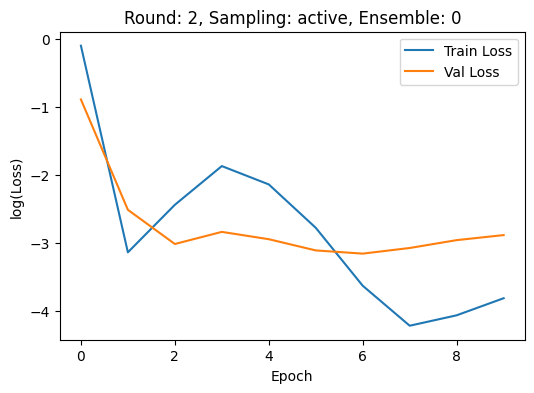

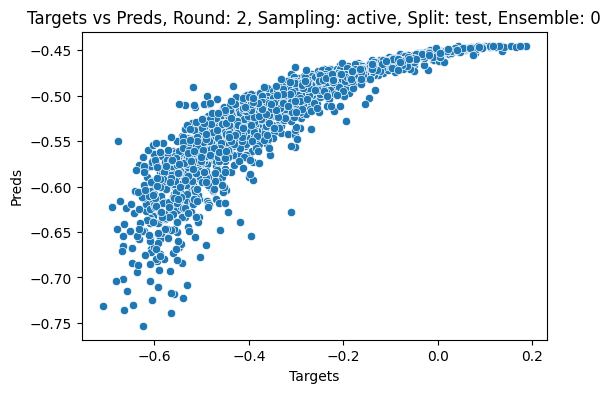

In [7]:
# generate a few plots to confirm that pipeline ran correctly
fig = active_learner.plot_loss_curves(round=2, sampling_type='active', ensemble=0)
fig = active_learner.plot_preds(round=2, sampling_type='active', split='test', ensemble=0)

In [9]:
# extract final predictions from model
preds = active_learner.preds
final_round_preds = preds[n_round-1]['active']['overall']

## Active Learning Pipeline with Replicates

Besides Norman2019, here we decomnstrate how to run active learning on another symeticalli screening data simpson with replicates. 

In [ ]:
# provide path to relevant data directories
data_source = 'simpson'
data_file = './data/simpson_gamma.csv'

time_label = datetime.now().strftime(r'%Y-%m-%d-%H-%M-%S')
result_dir = os.path.join('./results/active_learning/', f'{data_source}_{time_label}')
os.makedirs(result_dir)

n_rep = 3          # how many replicates to run of active learning pipeline

In [ ]:
# initialize active learner using same arguments as before
naiad_data = load_naiad_data(data_file)
active_learner = ActiveLearner(n_round = n_round, 
                               data = naiad_data,
                               n_ensemble = n_ensemble,
                               n_epoch = n_epoch,
                               n_sample = n_sample, 
                               test_frac = test_frac, 
                               early_stop = False,
                               device = device,
                               batch_size = batch_size,
                               method = method,
                               method_min = method_min)

active_learner_reps = ActiveLearnerReplicates(n_rep=n_rep, 
                                              overall_seed=seed, 
                                              active_learner=active_learner, 
                                              save_dir=result_dir,
                                              save_prefix=data_source)

In [ ]:
# run active learning with MPE (maximum predicted effect) selection
active_learner_reps.set_method(method='mean', method_min=True)          # method_min checks if we should minimize the value (for 'mean' it is set to True since we are minimizing cell viability)
results = active_learner_reps.run_replicates(parallel=True)             # parallel distributes the computation for faster processing
aggregated_results = active_learner_reps.aggregate_replicate_metrics(return_value=True)
active_learner_reps.save_aggregated_results(data_source)                # predictions for each round and replicate are stored in result_dir

Now let's generate some plots to visualize the active learning results. Since we selected new points to add to the 
active learning cycle using `method='mean'`, we must specify this same `method` for vusalizing the results.

We will visualize the results for both the MSE loss and the TPR for the mean-selection models and the random-selection models.

The `train` split shows performance on the training data, the `val` split shows performance on the validation data, and the `overall` split shows performance on both the training and actively-selected points.

In order to improve the performance of the active learning workflow, increase `n_epoch` in the ActiveLearner object, and `n_rep` in the ActiveLearnerReplicates object. For processing the Norman dataset in our accompanying publication, we used `n_epoch = 400` with `n_rep = 3`. 

In [ ]:
active_learner_reps.plot_aggregated_results(metrics = ['mse', 'tpr'], 
                                            splits = ['train', 'overall'],
                                            methods = 'mean')